
# Modeling House and Rent Prices Using Neighborhood Factors across the US
Anna Zhong, Austin Wu, Cody He, and Eliza Hale for <b>CS109</b>

<img src="website/images/sanfrancisco_houses3.jpg">

## Contents

<a href="#project_overview">1. Project Overview</a>

- <a href="#project_overview">Background and Motivation</a>
- <a href="#project_overview">Questions</a>
- <a href="#project_overview">Our Approach</a>

<a href="#data">2. Data</a>

- <a href="#data">2.1 House and Rental Price Data</a>
- <a href="#dem_data">2.2 Demographic Data</a>
- <a href="#biz_data">2.3 Business Data</a>
- <a href="#yelp_data">2.4 Yelp Data</a>
- <a href="#norm_transform">4.4 Normalizing and Transforming Features</a>

<a href="#exploration">3. Exploratory Analysis<a/>

- <a href="#exploration">3.1 Neighborhood Trends in Demographic and Business Type</a>
- <a href="#exploration_price">3.2 Price Trends</a>
- <a href="exploration_yelp">3.3 Yelp Business Trends

<a href="#modeling">4. Modeling</a>
- <a href="#modeling">4.1 Model Features</a>
- <a href="#baseline">4.2 Baseline Prediction</a>
- <a href="#regression">4.3 Regression (and other models)</a>
- <a href="#predictingpower">4.4 Checking Predicitng Power</a>
- <a href="#visualizingresults">4.5 Visualizing Our Models</a>

<a href="#conclusion">5. Conclusion</a>

<a id="project_overview"></a>
# 1. Project Overview

## Background and Motivation
As a group of four seniors who are all heading across the United States after graduation and entering the real world, a pressing issue on our minds has been finding our first apartment or house in our new city.  We all want to find a place to call home, while also making a sound financial decision. Where in the city should we live? Should we rent? Should we buy? 

We are also interested in learning more about our new homes and how the composition of the community and local economy affect the financial value of real estate in our areas. Our new cities will have neighborhoods with their own distinct character, from the posh, expensive district to the gritty, up and coming. We are interested in how the fabric of these communities in terms of demographics as well as business factors 

To look deeper into these questions, we decided to look at Price-to-Rent (PTR) ratios of different areas of the United States, which is the median existing home price divided by the average annual rent you would pay for a comparable home in the area. This is an informative metric for whether to buy or rent a property. If PtR ratios are very high in an area, then renting is likely a better deal. If PtR ratios are very low, then buying a home is probably the way to go.


## Questions

Initially we were interested in looking at changes in housing prices across the US from 2000 to 2010, and how differences in demographic and business features between regions might be able to predict the change in housing prices. First, we had to make a decision about the granularity of our data in terms of geographic divisions.  Did we want to look as neighborhoods within a specific city?  Or look at each city, county, or zipcode in the US? We chose to perform our analysis at the zipcode level in order to maximize the sample size for our regression and to eliminate the intra-region heterogeneity that exists with larger geographies. 


## Our Approach
We initially retrieved zipcode-level data for median house price per square foot across the united state from Zillow, a real estate database company. For our predictors, we aggregated data from a variety of sources. Initially, we used 2010 census data which detailed zipcode-level demographic data. As we iterated through various regression models, we sought to improve our models by adding new predictors to our regression. We aggregated jail data and prison indicator variables (i.e. whether or not there is a jail in a zipcode) from enigma.io, median income data, number of businesses, from Yelp.  We also. We also built a python script that would allow us to use features from Census data that only existed at the county level and mapped the values to the corresonding zipcodes within the county. We gathered our predictors and merged them with the housing price data by zipcode.

We first regressed census data along with jail/prison data on change in housing prices from 2000 to 2010. Our first model had very low explanatory power, so we sought more features. However, as we thought about the story we wanted to tell, we started thinking that examining other response variables might lend to more interesting and easily interpretable conclusions. We looked at a Zillow metric for home values that accounts for some biases that come with using their raw house price data. We also eventually looked at price-to-rent ratio (PTR).

With regards to gathering and organizing our data, some of our data, like the 2010 census data and the Zillow real estate data, we were able to download tables that we converted to pandas and cleaned by dropping the NANs in the years we wished to analyze and other miscellenaeous modifications. We stored our pandas dataframes by pickling them.
For Yelp we randomly sampled zipcodes, grabbed businesses in categories in active, arts, education, nightlife, pets, shopping, restaurants, and took the proportion of busineseses in each category. For all of our features, we considered if we needed to transform or normalize the data, and did so, if necessary. For some features, where a large fraction of the observed data was a single value, we made binary indicator variables.

Eventually, the final model progress was: forward variable selection using ordinary least squares regression, linear regression with lasso regularization, linear regression with ridge regularization, and finally, support vector machines. We also employed k-fold validation and cross-validations for hyperparameters wherever necessary. Ultimately, our best model employed ridge regularization. Below, we will walk you through our project in detail. Please reference the following iPython Notebooks for even greater detail in metholodgy: <b>Data Wrangling</b>, <b>Yelp Models</b>, and <b>Feature Selection and Modeling</b>.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

<a id="data"></a>
# 2. Data

<a id="data"></a>
## 2.1 House and Rental Price Data

All of the data for our house prices and rental prices came from Zillow at http://www.zillow.com/research/data/. We had originally wanted to model the delta between price data from two points in time (2000 vs 2010). This raised several concerns:

1. Is <b>delta</b> the best information to model?
2. Which years would be the most appropriate to do our analysis on given the data available to us for features of our model?

After some exploratory analysis (simple linear regressions using our demographic data, described below) on the <b>delta</b>, we quickly saw that it would be difficult to model the change in prices on static demographic data alone (we think that it would require time series analysis, and more importantly, several years of demographic data, which was impossible to gather in this short time frame because US census data categories vary by year).

This is what led us to temporarily switch to attempting to model the housing prices alone (rather than the change in housing prices). Additional research online, on the topic of predicting housing prices, suggested that we ought to look at the ratio of housing prices to rental prices, or price to rent ratio (PTR ratio). A ratio helps illuminate whether it would be prudent to buy a house or to rent: a high ratio suggests that housing prices far exceed renting prices, so renting would be a better option, whereas a low ratio suggests that housing prices are low, and buying would be a better option.

With this in mind, we looked for rental price data from Zillow. Since Zillow only contained rental data from 2011 onward, we were limited to this in scope. With this in mind, we decided to proceed modeling the 2015 PTR ratio with a 2011 PTR baseline, along with various features from demographic and business data as well we describe in the next few sections. For both the housing prices and rental prices we used the "median price per square foot" with regard to each Zip Code to keep the scales the same.

In [3]:
pd.read_pickle('data/housing_rental_ratio.pkl').head()

,RegionName,r_agg_2011,r_agg_2015_adj,r_pct_delta,h_agg_2011,h_agg_2015_adj,h_pct_delta,ratio_2011,ratio_2015,ratio_pct_delta
0,11368,1.868000,2.188278,1.171455,373.833333,431.274105,1.153653,16.677076,16.423646,0.984804
1,79936,0.744167,0.694379,0.933096,80.333333,75.060164,0.934359,8.995894,9.008072,1.001354
2,60629,1.197000,1.180207,0.985971,107.166667,113.430961,1.058454,7.460782,8.009253,1.073514
3,90650,1.524333,1.640026,1.075898,228.750000,292.549418,1.278905,12.505467,14.865076,1.188686
4,11226,1.014000,1.277783,1.260141,309.166667,416.876846,1.348389,25.408174,27.187509,1.070030


<a id="dem_data"></a>
## 2.2 Demographic Data

To find demographic data, we took data from the 2010 Census on zipcodes across the US. This data information on demographics such as sex, age, and race. It also gave us information on household  composition: the percentage of households that have single male and female residents, the percentage of households with single mothers, percentage of households that were family households or non-family households, the percentage of households that had children or seniors, etc. We also integrated jail and prison data to provide a more complete view of the demographic distribution of the zip code.

To see precisely how files were cleaned, please take a look at the <b>Data Wrangling</b> iPython Notebook.

In [4]:
prison = pd.read_pickle('data/prison_binary.pkl').drop('state', 1).rename(columns = {'zip': 'zipcode'})
jail = pd.read_pickle('data/jail_binary.pkl').rename(columns = {'zip': 'zipcode'})
demographics = pd.read_pickle('data/cleaned_demographic_features.pkl').drop(['GEO.id', 'GEO.display-label'], 1)
demographics = demographics.rename(columns = {'GEO.id2': 'zipcode'})

There are too many demographic variables to see them all here, so to see the full documentation on the variable name encoding, please take a look at the <b>Data Wrangling</b> iPython Notebook.

In [5]:
demographics.head()

,zipcode,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056
1,00601,18570,12.8,16.2,13.9,11.7,13.3,13.1,10.2,5.7,3.1,48.9,6.6,8.5,6.9,5.4,6.3,6.3,4.9,2.7,1.3,51.1,6.3,7.7,7,6.3,6.9,6.8,5.3,2.9,1.8,93.1,3.1,0.4,0,0,99.5,77.8,5.1,2.6,20.3,9.6,20.3,10.2,3.3,10.1,5.5,39.5,29,84.3,15.7,2.9,0.5,2.84,3.27,7744,2.87
2,00602,41520,11.5,15.2,13.5,12.9,14.6,14,10.1,5.7,2.3,49.1,5.9,7.7,6.7,6.4,7,6.8,4.9,2.6,1.1,50.9,5.6,7.5,6.8,6.5,7.6,7.2,5.2,3.1,1.3,86.7,5.3,0.3,0.1,0,99.4,77.6,5.1,2.1,17.4,8,20.5,10.5,3,10,4.9,37.6,25.9,83,17,2.6,1.3,2.76,3.20,18073,2.62
3,00603,54689,12.2,14.2,13,13,12.7,12.6,12,7,3.3,48.6,6.4,7.3,6.5,6.4,6,5.8,5.6,3.2,1.4,51.4,5.8,7,6.5,6.6,6.6,6.7,6.4,3.7,2.1,82.9,7.6,0.3,0.2,0,98.5,71.1,4.7,1.7,22,10.9,26.4,12.7,4.1,13.8,6.8,34,31.1,82.5,17.5,3.6,1.5,2.53,3.06,25653,2.51
4,00606,6615,12.8,15.1,14.7,12.1,13.1,13.4,10.5,5.5,2.9,49.4,6.6,7.5,7.1,6.1,6.5,6.3,5.2,2.6,1.4,50.6,6.2,7.5,7.6,6,6.6,7,5.4,2.9,1.5,88.9,4.7,0.4,0,0.1,99.4,74.6,6.2,2.7,18.4,8.1,22.8,12.7,4.5,10.1,4.7,37.5,28.4,83.6,16.4,1.7,0.8,2.75,3.24,2877,2.83
5,00610,29016,11.8,15.1,12.6,13.4,13.9,12.6,11.2,6.7,2.8,48.6,6.2,7.7,6.4,6.6,6.5,5.9,5.1,3.2,1.1,51.4,5.6,7.5,6.2,6.9,7.4,6.7,6.1,3.5,1.7,82,7.2,0.3,0.1,0,99.2,74.4,4.9,1.9,19.9,9.4,22.8,11,3.4,11.9,5.8,36.5,29.4,85.9,14.1,1.9,0.8,2.67,3.14,12618,2.66


In [6]:
prison.head()

,zipcode,prison
0,35034,1
1,36089,1
2,35023,1
3,36025,1
4,36017,1


In [7]:
jail.head()

,zipcode,jail
0,36067,1
1,36507,1
2,36016,1
3,35034,1
4,35121,1


<a id="biz_data"></a>
## 2.3 Business Data

We also retrieved some business data from each zipcode from the US Census. This included the number of businesses within the zipcode, the size and amount of the payroll, as well as the median income of residents of each zipcode. This data was current to 2010.

To see precisely how files were cleaned, please take a look at the <b>Data Wrangling</b> iPython Notebook.

In [8]:
bus_patterns = pd.read_pickle('data/business_patterns.pkl').drop('Geographic area name', 1)
bus_patterns = bus_patterns.rename(columns = {'Number of establishments':'n_establishments'})
income = pd.read_pickle('data/medianIncome.pkl')

In [9]:
bus_patterns.head()

,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,zipcode
1,448,9185,70693,314508,01001
2,570,15633,82069,351589,01002
3,16,168,1297,5761,01003
4,21,189,1710,7241,01004
5,96,926,5698,24382,01005


In [10]:
income.head()

,zipcode,median_income
0,00601,13318
1,00602,14947
2,00603,14437
3,00606,11155
4,00610,16367


<a id="yelp_data"></a>
## 2.4 Yelp Data

To explore our business data in more detail than just the number of businesses present, we decided to look at what types of businesses are present in zip code geographies. To do this, we scraped Yelp data using the Yelp API. See the <b>Data Wrangling</b> iPython Notebook to see the details on this method. There were 17 categories of businesses that we looked for using the API:

In [11]:
categories = [
    'active',
    'arts',
    'beautysvc',
    'education',
    'financialservices',
    'food',
    'health',
    'hotelstravel',
    'massmedia',
    'nightlife',
    'pets',
    'professional',
    'publicservicesgovt',
    'realestate',
    'religiousorgs',
    'restaurants',
    'shopping'
]

Since the number of businesses varied by zipcode, we regularized the data by keeping track of the <b>fraction</b> of businesses in each category, and used this fraction as a feature. For example, if <b>02138</b> had 1,304 restaurants out of a total of 10,000 businesses, then the fraction in the column "restaurants" would be 0.1304. See the <b>Data Wrangling</b> iPython Notebook for the complete metholodogy. The cleaned dataframe of features is:

In [12]:
pd.read_pickle('data/yelpexport.pkl').head()

,active,arts,auto,beautysvc,education,financialservices,food,health,hotelstravel,massmedia,nightlife,pets,professional,publicservicesgovt,realestate,religiousorgs,restaurants,shopping,zipcode
0,0.044293,0.018750,0.101630,0.089946,0.015761,0.015489,0.107337,0.063587,0.070924,0.001087,0.029891,0.029891,0.044293,0.005707,0.020109,0.001359,0.172011,0.167935,11705
0,0.033516,0.012996,0.110123,0.088919,0.010260,0.015732,0.084131,0.093707,0.049932,0.000000,0.026676,0.020520,0.022572,0.004788,0.044460,0.008208,0.202462,0.170999,37128
0,0.044632,0.027744,0.113390,0.028951,0.019300,0.006031,0.075995,0.048251,0.125452,0.000000,0.007238,0.049457,0.106152,0.002413,0.168878,0.001206,0.044632,0.130277,98260
0,0.037657,0.016736,0.146444,0.029289,0.008368,0.000000,0.054393,0.033473,0.184100,0.004184,0.008368,0.037657,0.100418,0.008368,0.083682,0.000000,0.108787,0.138075,21660
0,0.047544,0.051506,0.083994,0.045166,0.020602,0.004754,0.061014,0.108558,0.148177,0.001585,0.002377,0.040412,0.116482,0.003170,0.107765,0.002377,0.032488,0.122029,93924


<a id="norm_transform"></a>
## 2.4 Normalizing and Transforming Features

We used all the above features, besides Yelp  features, to predict the PRT ratio for 2015.

We plotted all of our features to visualize their distributions:

In [13]:
# gather all features we have downloaded thus far - make sure they all have zipcode data
prison = pd.read_pickle('data/prison_binary.pkl').drop('state', 1).rename(columns = {'zip': 'zipcode'})
jail = pd.read_pickle('data/jail_binary.pkl').rename(columns = {'zip': 'zipcode'})
demographics = pd.read_pickle('data/cleaned_demographic_features.pkl').drop(['GEO.id', 'GEO.display-label'], 1)
demographics = demographics.rename(columns = {'GEO.id2': 'zipcode'})
bus_patterns = pd.read_pickle('data/business_patterns.pkl').drop('Geographic area name', 1)
bus_patterns = bus_patterns.rename(columns = {'Number of establishments':'n_establishments'})
income = pd.read_pickle('data/medianIncome.pkl')

# merge all features into single data frame
all_features = demographics.merge(bus_patterns, how='inner', on='zipcode').fillna(0)
all_features = all_features.merge(prison, how='left', on='zipcode').fillna(0)
all_features = all_features.merge(jail, how='left', on='zipcode').fillna(0)
# where median income data is missing, fill with median income across all zipcodes
med = np.median(income.median_income.dropna().values)
all_features = all_features.merge(income, how='left', on='zipcode')
all_features.median_income.fillna(med, inplace=True)

zipCodeStrings = all_features.zipcode
all_features = all_features.astype('float')

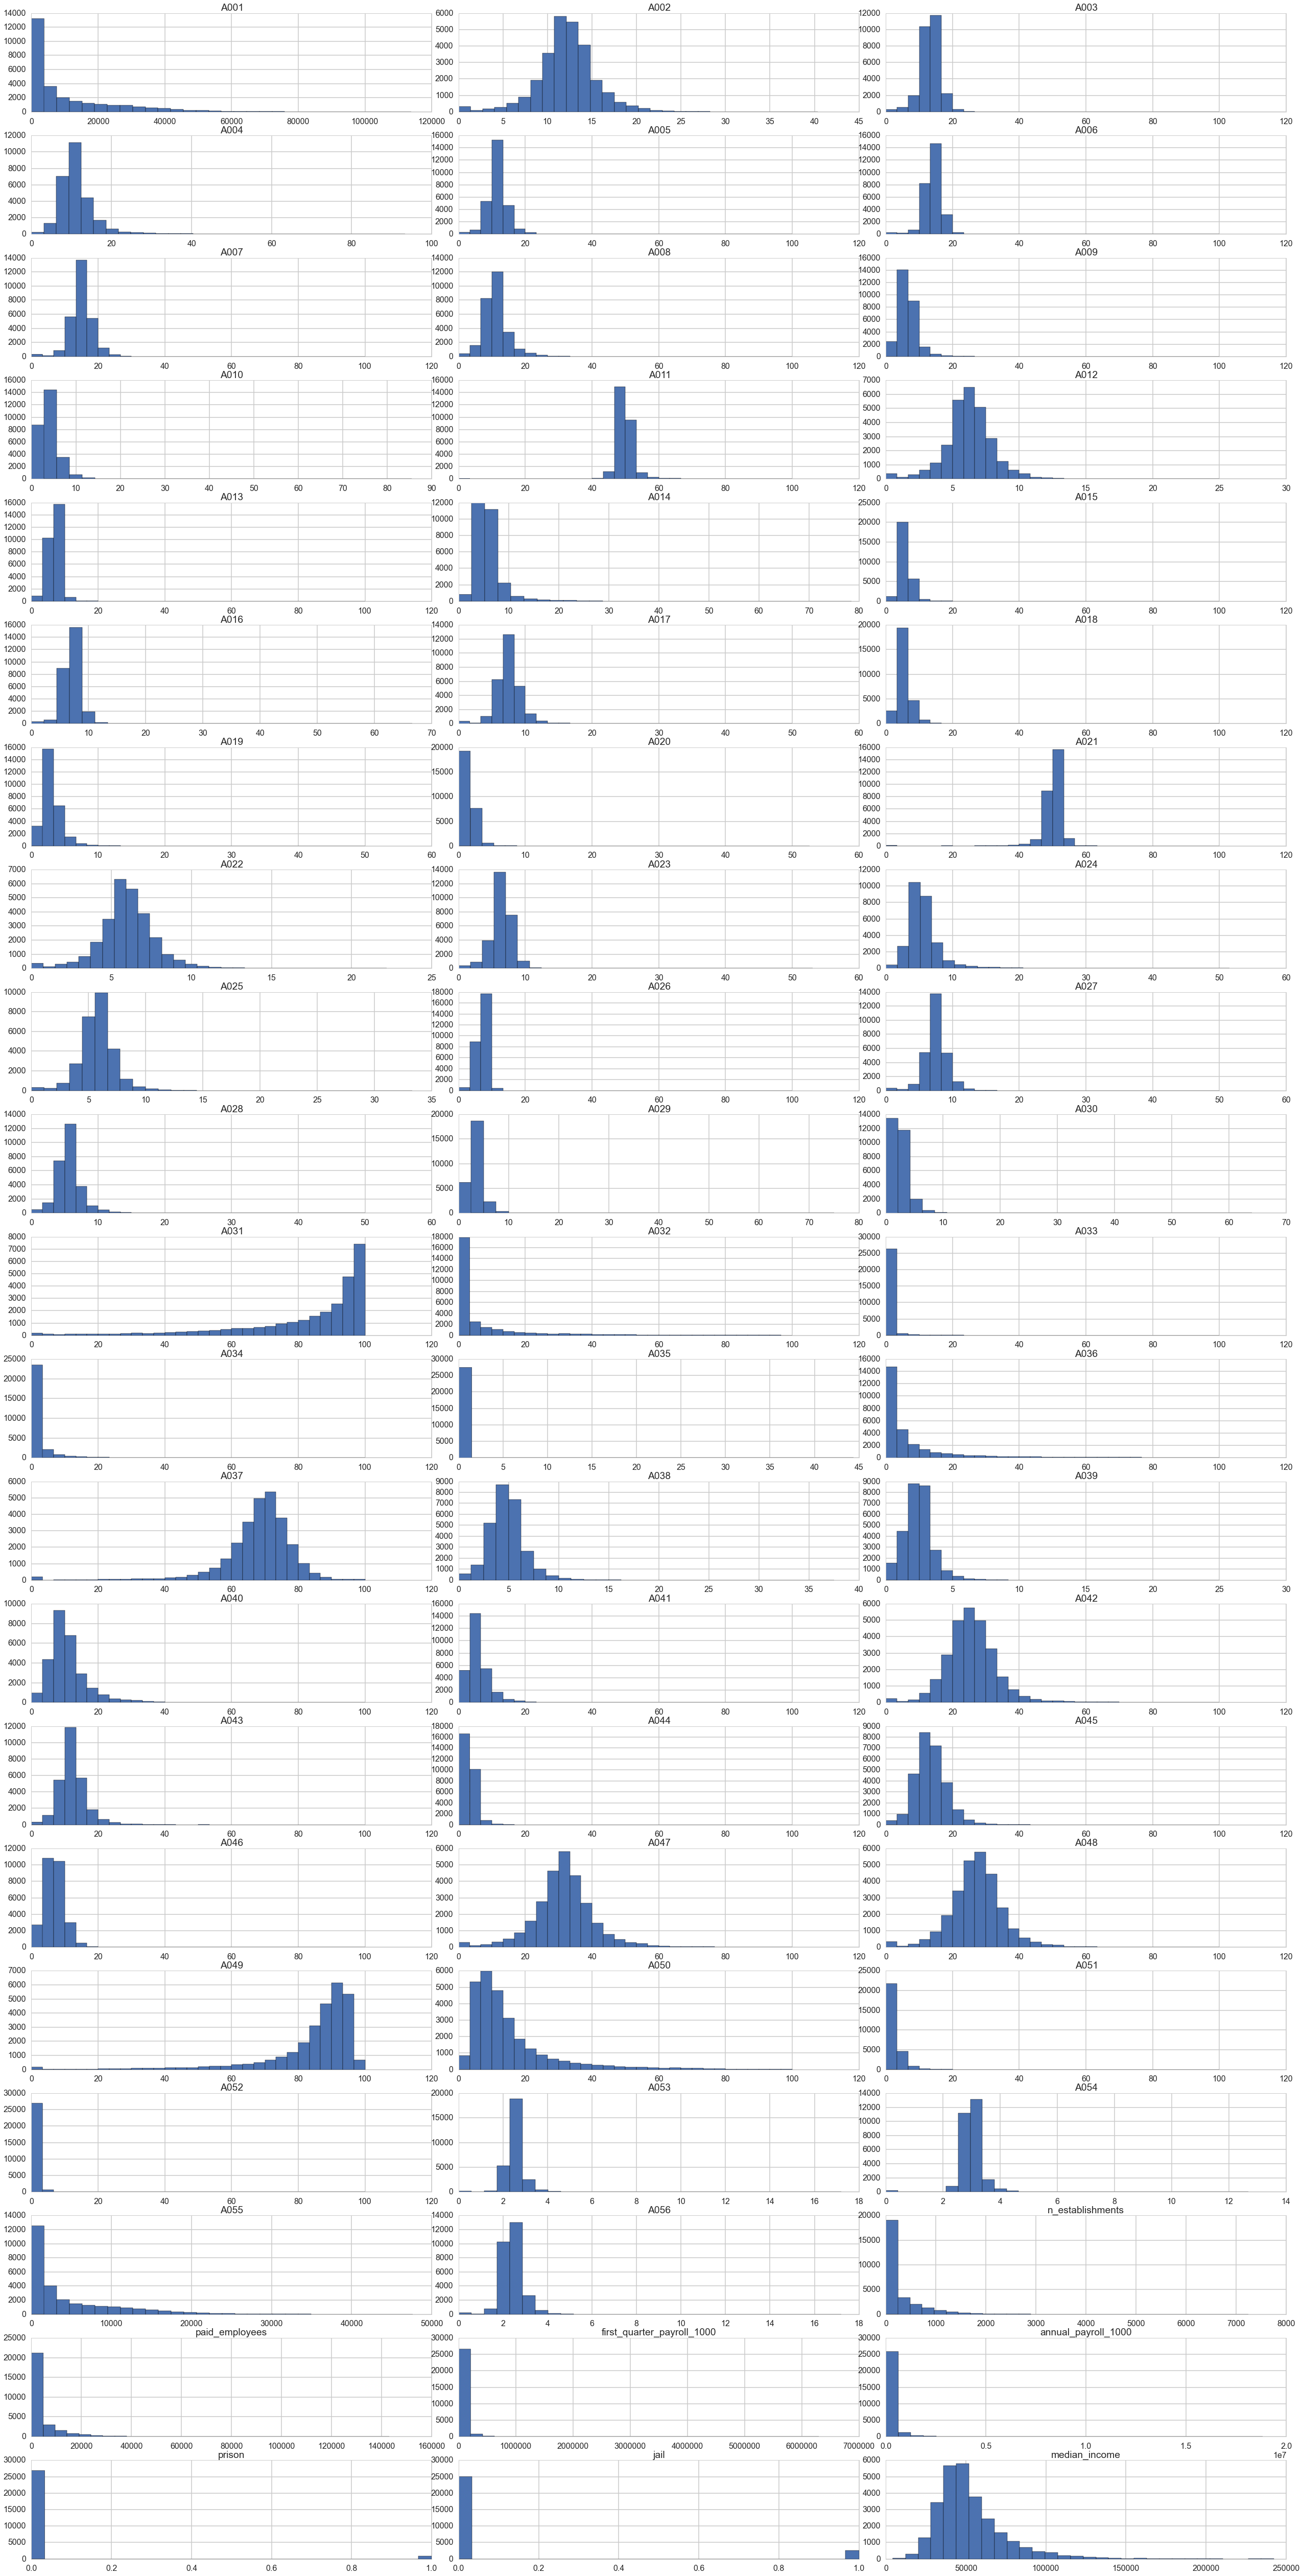

In [14]:
features = all_features.columns[1:]
if len(features)%3 == 0 :
    nROW = len(features)/3
else :
    nROW = np.ceil(len(features)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))
f.tight_layout()

for i in xrange(len(features)):
    plt.subplot(nROW,nCOL,i+1)
    ax = all_features[features[i]].hist(bins = 30)
    ax.set_title(features[i])

We noticed that a few of the features were right-skewed, so we log transformed these to make them more normally distributed.  We then normalized all features except the indicator variables jail and prison.

Before normalizing the features we split them into a training and a test set.  We got the mean and standad deviation from the training set, and used these to normalize both the training and the test sets.  This was to avoid information leakage from the test set into the training set.

In [15]:
from sklearn.cross_validation import train_test_split
# split into training and test sets
itrain, itest = train_test_split(xrange(all_features.shape[0]), train_size=0.8)

mask=np.ones(all_features.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

print 'samples in training set = %s \nsamples in test set = %s'%(mask.sum(), mask.shape[0] - mask.sum())

samples in training set = 22122 
samples in test set = 5531


In [16]:
from sklearn.preprocessing import StandardScaler
all_features_stand_trans = all_features.copy()

right_skewed_columns = ['A020', 'A030', 'A032', 'A036', 'A034', 'A050', 'A051', 'A055', 'n_establishments', 'paid_employees']

# log transform all right_skewed columns (np.log1p does natural log of 1 plus input: ln(1 + x)) this avoids
# getting negative infinity when x = 0
log_features = all_features_stand_trans[right_skewed_columns].values.T
for i in xrange(log_features.shape[0]):
    log_features[i] =  np.log1p(log_features[i])
log_features_df = pd.DataFrame(log_features.T, columns = right_skewed_columns)

# drop right-skewed columns from dataframe
for col in right_skewed_columns:
    all_features_stand_trans = all_features_stand_trans.drop(col, 1)
# merge with new df that has log of right-skewed data
all_features_stand_trans = all_features_stand_trans.merge(log_features_df, how='outer', left_index=True, right_index=True)

# standardize all but binary features (i.e indicator variables)
stand_columns = all_features.columns[1:-3].values.tolist() + [all_features.columns[-1]]

train_raw = all_features_stand_trans[mask]

# initialize standardizer on training set
standardizer = StandardScaler().fit(train_raw[stand_columns])
# standardize all data
stand_data = pd.DataFrame(columns=stand_columns, data=standardizer.transform(all_features_stand_trans[stand_columns]))
# drop old non-standardized columns from dataframe
for col in stand_columns:
    all_features_stand_trans = all_features_stand_trans.drop(col, 1)

# merge dftouse with new df that has standardized data
all_features_stand_trans = all_features_stand_trans.merge(stand_data, how='outer', left_index=True, right_index=True)
all_features_stand_trans['zipcode'] = zipCodeStrings

# all_features_stand_trans[mask].to_pickle('/data/train_all_features_norm_and_transform.pkl')
# all_features_stand_trans[~mask].to_pickle('/data/test_all_features_norm_and_transform.pkl')

Visualize the transformation and visualization of the data

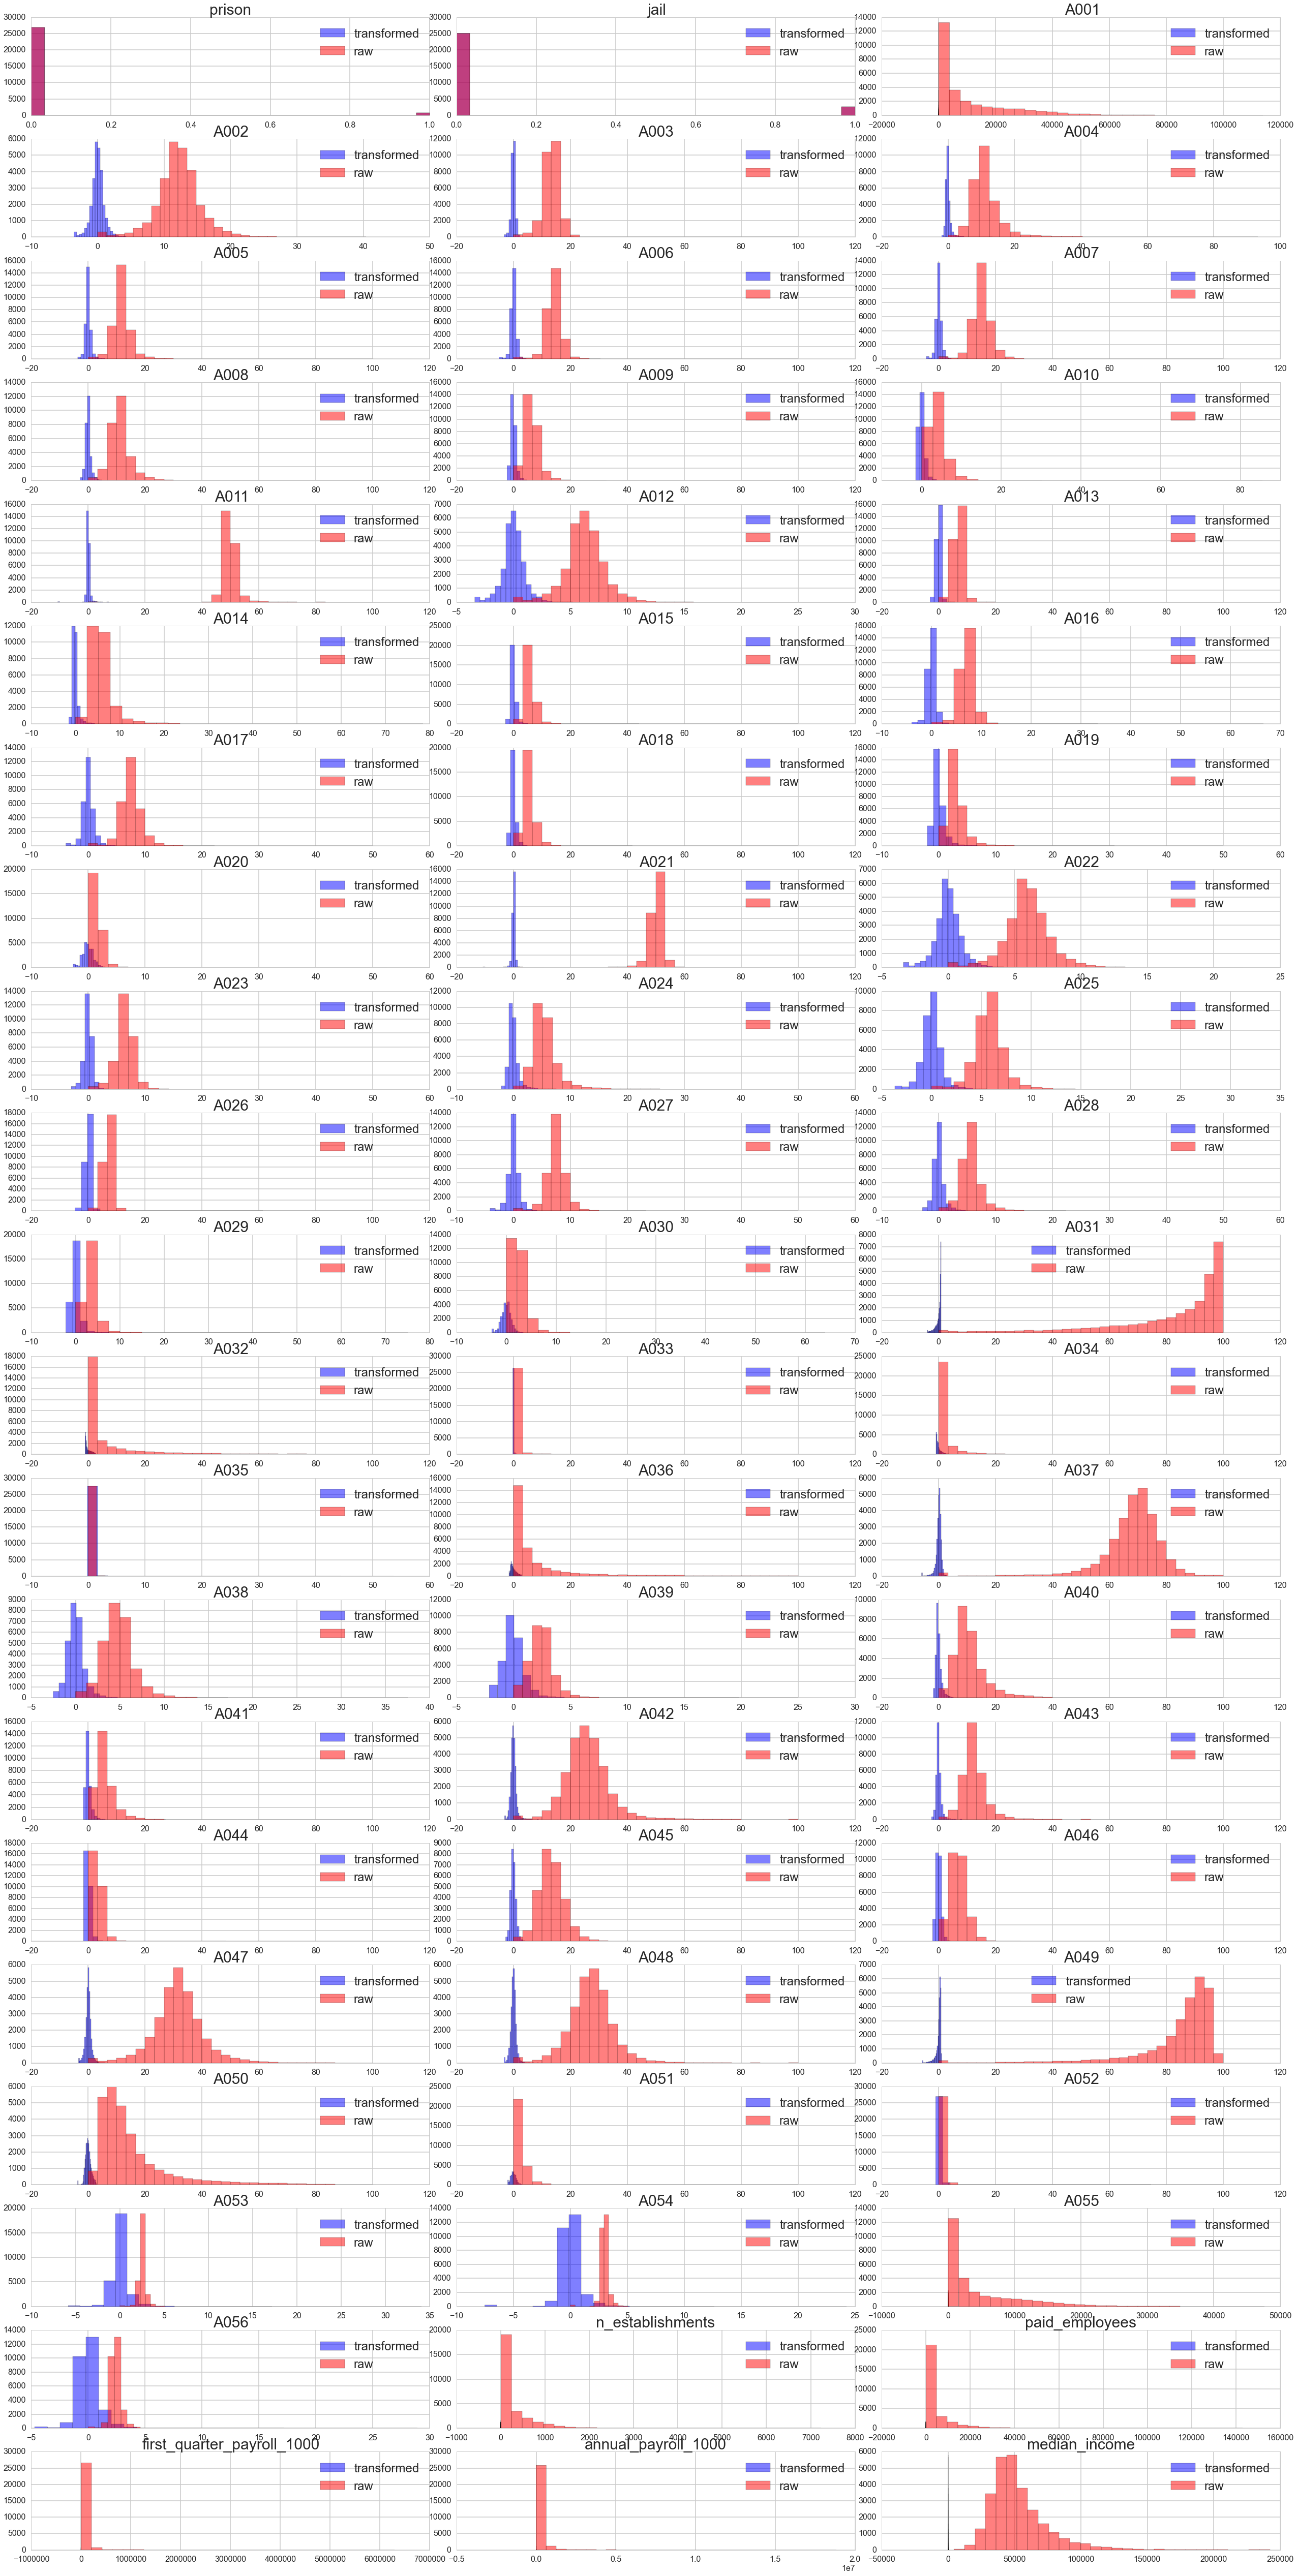

In [17]:
features_st = all_features_stand_trans.columns[1:]
if len(features_st)%3 == 0 :
    nROW = len(features_st)/3
else :
    nROW = np.ceil(len(features_st)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))
f.tight_layout()

for i in xrange(len(features_st)):
    plt.subplot(nROW,nCOL,i+1)
    ax = all_features_stand_trans[features_st[i]].hist(bins = 30, color='b', alpha=.5, label='transformed')
    all_features[features_st[i]].hist(bins = 30, color='r', alpha=.5, label='raw')
    ax.legend(loc='best', fontsize=24)
    ax.set_title(features_st[i], fontsize=30)

<a id="exploration"></a>
# 3. Exploratory Data Analysis

<a id="exploration"></a>
## 3.1 Neighborhood Trends in Business and Demographics

Demographic data: do a heat map of single householder and others (minority races?) 

Business data: rank industries by number of zip codes with that industry as the most popular, map out business data as well?

<a id="exploration_price"></a>
## 3.2 House and Rent Price Trends

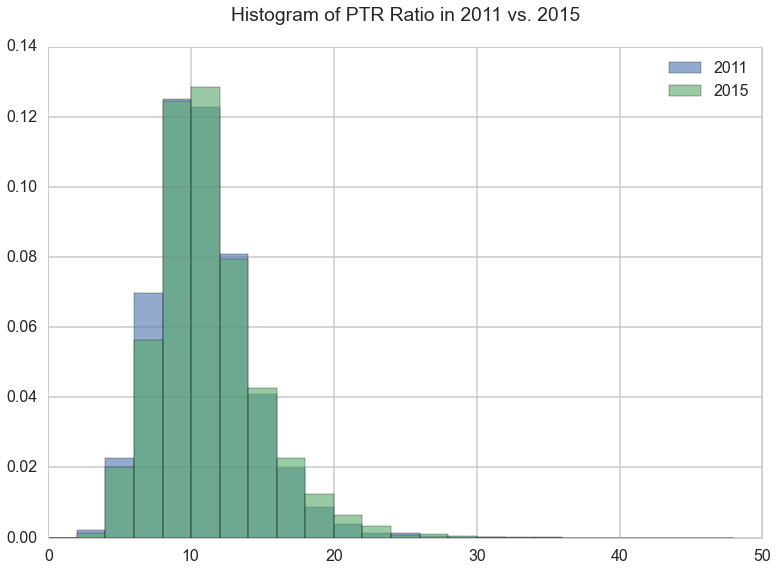

In [18]:
df = pd.read_pickle('data/housing_rental_ratio.pkl')
setbins = range(0,50,2)

plt.hist(df['ratio_2011'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2011');
plt.hist(df['ratio_2015'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2015');
plt.title('Histogram of PTR Ratio in 2011 vs. 2015\n');
plt.legend();

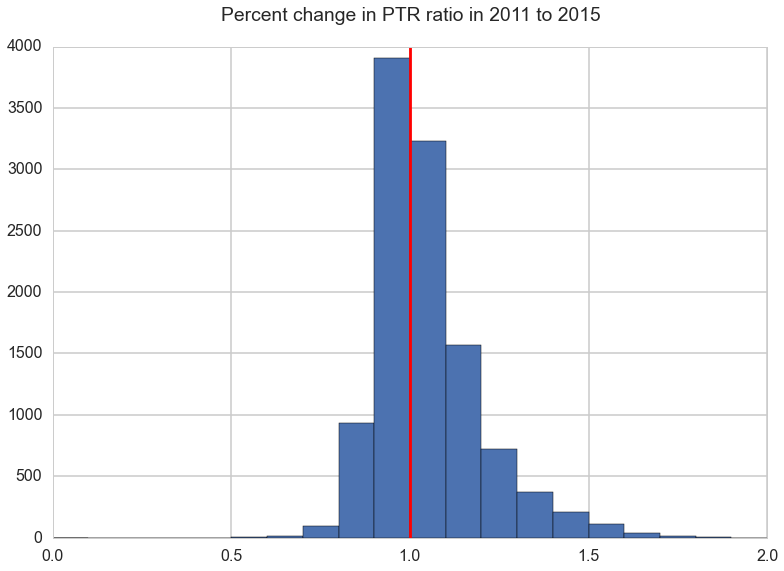

In [19]:
plt.hist(df['ratio_pct_delta'], bins=np.arange(0,2.1,0.1));
plt.axvline(x=1, color="red");
plt.title('Percent change in PTR ratio in 2011 to 2015\n');

From the first histogram above, it seems that PTR, on average, increases between 2011 and 2015. However, based on the second histogram above, as well as the third choropleth map below, there is still a substantial fraction of zip codes where the PTR decreases.

<img src="images/PriceToRent.png">
We generated some choropleth maps using d3 to visualize what some of these metrics looked like across the country from 2011 to 2015. This is displayed on the county level, with data lacking in the white areas. With regards to price-to-rent ratio, we saw that it seemed to be getting cheaper to rent than to buy a home (as indicated by higher price-to-rent ratios) in California in 2015 compared to 2011. 

<img src="images/Delta.png">
This visualization, which shows the percentage change in the price-to-rent ratio, confirms our hypothesis about renting in California. Along with California, Michigan and the south of Florida seem to be areas where it is becoming increasingly cheaper to rent than to buy a home.

<a id="exploration_yelp"></a>
## 3.3 Yelp Business Trends

The Yelp Business data offered a lot of heterogeneity amongst features and zipcodes, as we can see in this choropleth of the prevalence of restaurants in zipcodes across the country. Our data set for Yelp data is only about 900 zipcodes.

# INCOMPLETE

We did some preliminary data analysis on these Yelp features, but found them to be rather subpar in their predictive power. Using feature selection from linear regression, and then more advanced methods like Lasso, Ridge Regression, and SVM, we tried to fit these features on PTR, but without too much success. Furthermore, scraping this data from Yelp took a lot of time (17 API calls for each zip code), and with roughly 10,000 zip codes in our testing and training dataframes, combined, it was impracticable to continue using these features (sadly).

<a id="modeling"></a>
# 4. Modeling

We chose to focus on linear regression because we were largely interested in the direct correlation and predictive potential of certain features.  We based out baseline model on the PTR ratio for 2011, as this seemed the natural choice and because it seemed to be the single best predictor from early exploratory analysis.

<a id="modeling"></a>
## 4.1 Model Features

We decided to use forward selection to select features for our regressions, this is the function for forward feature selection.

We experimented with the threshold for improvement (see \*\*\* threshold \*\*\* below), but found that our model became significantly worse with a tighter threshold.  Therefore we decided to keep features if they improved the model at all - this still lead to the pruning of a little less than 1/3 of the features.

In [20]:
# with help from http://planspace.org/20150423-forward_selection_with_statsmodels/
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        # *** threshold ***
        if current_score < (best_new_score * 1):
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    
    model = smf.ols(formula, data).fit()
    return (model, formula)

Import 2015 PTR ratio which is our response, and save the 2011 PTR ratio to be used as a feature

In [21]:
%%capture
ratio_response = pd.read_pickle('data/housing_rental_ratio.pkl').rename(columns = {'RegionName': 'zipcode'})
ratio_2015_response = ratio_response[['zipcode','ratio_2015']]

# create ratio_2011 feature to be predictor!
ratio_2011_feature = ratio_response[['zipcode','ratio_2011']]

ratio_2011_feature['zipcode'] = ratio_2011_feature['zipcode'].astype('str')
ratio_2015_response['zipcode'] = ratio_2015_response['zipcode'].astype('str')

Import features which have already been normalized and transformed if they were very right-skewed

In [22]:
train_set_t = pd.read_pickle('data/train_all_features_norm_and_transform.pkl')
test_set_t = pd.read_pickle('data/test_all_features_norm_and_transform.pkl')
# save training and testing indices for later use
itrain_t_df = pd.DataFrame(train_set_t.index).rename(columns={0: 'ind'})
itest_t_df = pd.DataFrame(test_set_t.index).rename(columns={0: 'ind'})

features_t = pd.concat([train_set_t, test_set_t])
# merge to add PTR ratio for 2011 as a feature
features_t = features_t.merge(ratio_2011_feature, how='inner', on='zipcode')

merge the feature df with the response df for splitting into training at test sets

In [23]:
merged_ratio_2015 = ratio_2015_response.merge(features_t, how='inner', on=['zipcode'])
merged_ratio_2015 = merged_ratio_2015.astype('float')
merged_ratio_2015 = merged_ratio_2015.rename(columns={'ratio_2015':'response'})

# split into training and test sets
ratio_2015_train = merged_ratio_2015.merge(itrain_t_df, how='inner', right_on='ind', left_index=True)
ratio_2015_test = merged_ratio_2015.merge(itest_t_df, how='inner', right_on='ind', left_index=True)
print '%s samples in training set \n%s samples in test set'%(ratio_2015_train.shape[0], ratio_2015_test.shape[0])

8201 samples in training set 
2105 samples in test set


function to calculate RMSE (root mean squared error).  We thought it would be good to compare our results using both r-squared and rmse, as r-squared increases with the number of

In [24]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

Use forward selection to select best features, and calculate rmse for basic OLS regression on these features

In [25]:
import time
import patsy
from statsmodels.api import add_constant
start_time = time.time()

bestmodel_ratio_2015 = forward_selected(ratio_2015_train.drop(['zipcode','ind'],1), 'response')

formula = bestmodel_ratio_2015[1].replace('response ~ ','')
data = ratio_2015_test.drop(['zipcode','ind'],1).dropna()
response = data['response']
data = data.drop('response',1)

df = patsy.dmatrix(formula, data=data)
pred = bestmodel_ratio_2015[0].predict(df, transform=False)

ols_rmse = get_rmse(response, pred)

print '%s seconds to train model'%(time.time() - start_time)
print 'Response Variable: Ratio 2015'
print 'RMSE for OLS is ' + str(ols_rmse)

66.5725278854 seconds to train model
Response Variable: Ratio 2015
RMSE for OLS is 1.14147816188


In [26]:
bestmodel_ratio_2015[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1909.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        19:25:46   Log-Likelihood:                -11857.
No. Observations:                7685   AIC:                         2.380e+04
Df Residuals:                    7644   BIC:                         2.408e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      1.7364      0.062     27.981      0.000         1.615     1.858
ratio_2011                     0.8592      0.006    151.170      0.000         0.848     0.870
A036                           0.1550      0.023      6.861      0.000         0.111     0.199
A034                           0.1890      0.022      8.515      0.000         0.145     0.233
A032                          -0.5289      0.028    -18.726      0.000        -0.584    -0.474
A056                           0.6326      0.040     15.627      0.000         0.553     0.712
A002                          -0.3645      0.047     -7.809      0.000        -0.456    -0.273
A031                          -0.5173      0.036    -14.208      0.000        -0.589    -0.446
A052                           0.1313      0.019      6.863      0.000         0.094     0.169
median_income                  0.2550      0.025     10.121      0.000         0.206     0.304
A037                          -1.2984      0.099    -13.075      0.000        -1.493    -1.104
A039                           0.5121      0.055      9.392      0.000         0.405     0.619
A014                          -0.2174      0.117     -1.861      0.063        -0.446     0.012
A042                          -3.2319      2.130     -1.517      0.129        -7.408     0.944
A040                          -0.1489      0.085     -1.748      0.081        -0.316     0.018
A001                           0.1083      0.020      5.421      0.000         0.069     0.147
A049                           0.1529      0.055      2.773      0.006         0.045     0.261
A051                           0.1667      0.026      6.406      0.000         0.116     0.218
A004                          -0.0766      0.109     -0.700      0.484        -0.291     0.138
A038                          -0.2871      0.061     -4.710      0.000        -0.407    -0.168
first_quarter_payroll_1000     0.0540      0.013      4.217      0.000         0.029     0.079
paid_employees                -0.2071      0.070     -2.958      0.003        -0.344    -0.070
A030                          -0.0677      0.054     -1.264      0.206        -0.173     0.037
A005                           0.2290      0.078      2.950      0.003         0.077     0.381
A018                           0.3436      0.069      4.984      0.000         0.208     0.479
A054                           0.3726      0.134      2.789      0.005         0.111     0.634
A016                           0.1030      0.044      2.347      0.019         0.017     0.189
A020                           0.1118      0.055      2.050      0.040         0.005     0.219
A019                          -0.1145      0.073     -1.574      0.115        -0.257     0.028
A048                           0.2044      

<a id="baseline"></a>
## 4.2 Baseline Prediction

From plotting the PTR ratio for 2015 against the PTR ratio for 2011, we realized that this was going to be a very good predictor.

# PLOT HERE

First we built a very basic model that used the average of the 2011 PTR ratio to predict the 2015 PTR ratio

In [27]:
train_ratio_2015_observed = ratio_2015_train['ratio_2011'].dropna().tolist()
test_ratio_2015_observed = ratio_2015_test['response'].dropna().tolist()
train_ratio_2015_mean = np.mean(train_ratio_2015_observed)

baseline_rmse = get_rmse(np.array(test_ratio_2015_observed), np.array([train_ratio_2015_mean]*len(test_ratio_2015_observed)))

print 'Response Variable: Ratio 2015'
print 'RMSE for baseline - 2011 PTR average is ' + str(baseline_rmse)

Response Variable: Ratio 2015
RMSE for baseline - 2011 PTR average is 3.548822241


Then we used the exact 2011 PTR ratio values to predict the 2015 values

In [28]:
temp = ratio_2015_test[['response','ratio_2011']].dropna()
test_ratio_2015_obs = temp.response.tolist()
ratio_2011_obs = temp.ratio_2011.tolist()

baseline_ratio_rmse = get_rmse(np.array(test_ratio_2015_obs), np.array(ratio_2011_obs))

print 'Response Variable: Ratio 2015'
print 'RMSE for baseline - 2011 ratio is ' + str(baseline_ratio_rmse)

Response Variable: Ratio 2015
RMSE for baseline - 2011 ratio is 1.52600977525


As you can see, the rmse value for the second baseline model is much better, so that was the model we hoped our regressions would beat.

<a id="regression"></a>
## 4.3 Regression 

We used the features selected above for linear regression with ridge and lasso regularization.  We cross validated to select the best alpha regularization parameter.

In [29]:
best_features_ratio_2015 = bestmodel_ratio_2015[0].params.index.values.tolist() + ['response', 'zipcode']
bad_features_ratio_2015 = [el for el in ratio_2015_train.columns if (el not in best_features_ratio_2015)]

ratio_2015_train_best = ratio_2015_train.drop(bad_features_ratio_2015 + ['ind'], 1).dropna()
ratio_2015_test_best = ratio_2015_test.drop(bad_features_ratio_2015 + ['ind'], 1).dropna()
print 'number of features used = %s; number of unused features = %s'%(len(best_features_ratio_2015) - 2, len(bad_features_ratio_2015))

number of features used = 41; number of unused features = 25


In [30]:
%%capture
# create feature (X) and response (Y) matrices
X_train = ratio_2015_train_best.drop(['response','zipcode'], 1).values
Y_train = ratio_2015_train_best['response'].values
X_test = ratio_2015_test_best.drop(['response','zipcode'], 1).values
Y_test = ratio_2015_test_best['response'].values

### Lasso Regularization

In [31]:
from sklearn.linear_model import LassoCV
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lasso_model_ratio_2015 = LassoCV(alphas = alphas, verbose=0).fit(X_train, Y_train)
best_alpha_lasso = lasso_model_ratio_2015.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_lasso)

# calculate accuracy
training_accuracy = lasso_model_ratio_2015.score(X_train, Y_train)
test_accuracy = lasso_model_ratio_2015.score(X_test, Y_test)
print '#### based on the Linear Regression with Lasso Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

lasso_pred_ratio_2015 = lasso_model_ratio_2015.predict(X_test)
lasso_rmse = get_rmse(lasso_pred_ratio_2015, Y_test)

print 'Response Variable: House/Rental 2015 Ratio'
print 'RMSE for Lasso: ' + str(lasso_rmse)

----- 0.0795040130615 seconds to run ----- 
---- best alpha = 0.01 ----
#### based on the Linear Regression with Lasso Regularization ####
R-squared on training data: 0.91
R-squared on test data:     0.90
Response Variable: House/Rental 2015 Ratio
RMSE for Lasso: 1.15735294342


//anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


### Ridge Regularization

In [32]:
from sklearn.linear_model import RidgeCV
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model_ratio_2015 = RidgeCV(alphas = alphas).fit(X_train, Y_train)
best_alpha_ridge = ridge_model_ratio_2015.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_ridge)

training_accuracy = ridge_model_ratio_2015.score(X_train, Y_train)
test_accuracy = ridge_model_ratio_2015.score(X_test, Y_test)
print '#### based on the best Linear Regression with Ridge Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

ridge_pred_ratio_2015 = ridge_model_ratio_2015.predict(X_test)
ridge_rmse = get_rmse(ridge_pred_ratio_2015, Y_test)

print 'Response Variable: Housing/Rental Ratio 2015'
print 'RMSE for Ridge: ' + str(ridge_rmse)

----- 0.0381350517273 seconds to run ----- 
---- best alpha = 10.0 ----
#### based on the best Linear Regression with Ridge Regularization ####
R-squared on training data: 0.91
R-squared on test data:     0.90
Response Variable: Housing/Rental Ratio 2015
RMSE for Ridge: 1.14202754673


Wahoo! Both our lasso and our ridge regularized linear regressions beat the basline 2011 PTR ratio model.  The regressions had higher r-squared values as well as lower rmse values. Let's take a look at the actual values of our coefficients ... 

In [108]:
import json
with open('data/feature_encoding.json') as data_file:
    feature_encoding = json.loads(data_file.read())

for feature in feature_encoding :
    text = feature_encoding[feature].split(' - ')[-2:]
    if len(text[1]) < 15 :
        feature_encoding[feature] = text[0] + ': '+ text[1]
    else :
        feature_encoding[feature] = text[1]

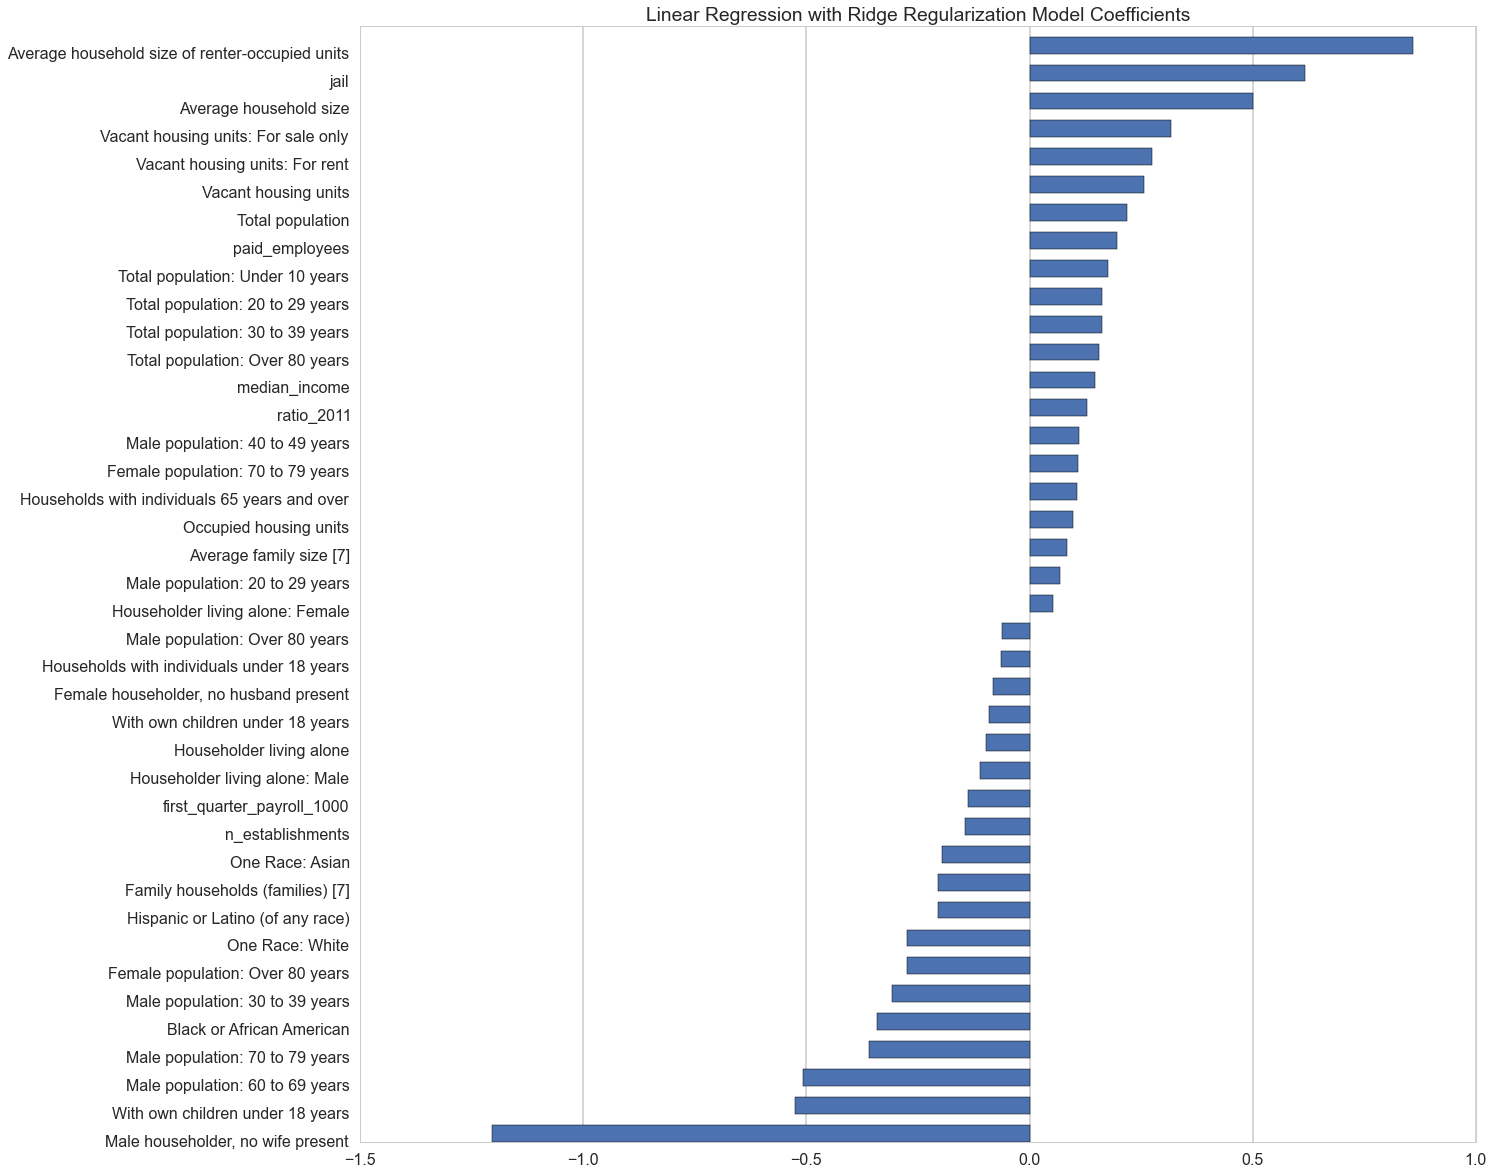

In [109]:
ridgeFeatures = pd.DataFrame()
ridgeFeatures['featureName'] = list(set(best_features_ratio_2015) - set(['Intercept','response','zipcode']))
ridgeFeatures['featureName'] = [feature_encoding[name] if 'A0' in name else name for name in ridgeFeatures.featureName]
ridgeFeatures['coefficients'] = ridge_model_ratio_2015.coef_
ridgeFeatures = ridgeFeatures.sort('coefficients')

y_pos = np.arange(len(ridgeFeatures.featureName)) * 5
plt.figure(figsize=(20, 20));
plt.barh(y_pos, ridgeFeatures.coefficients, align='edge', height=3);
plt.yticks(y_pos, ridgeFeatures.featureName);
plt.title('Linear Regression with Ridge Regularization Model Coefficients');
plt.grid(axis="y");
plt.show();

<a id="predictivepower"></a>
## 4.4 Checking Predictive Power

However, we wanted to make sure that the features besides 2011 PTR ratio were adding predictive value to our models.  So we compared these models to linear and ridge regularized linear regressions where 2011 PTR ratio was the only feature.

In [67]:
# create feature (X) and response (Y) matrices
X_train_small = ratio_2015_train_best['ratio_2011'].values
# add intercept to feature matrix - sklearn didn't like having only 1 feature
X_train_small = np.vstack((X_train_small, np.array([1]*X_train_small.shape[0]))).T
Y_train_small = ratio_2015_train_best['response'].values
X_test_small = ratio_2015_test_best['ratio_2011'].values
X_test_small = np.vstack((X_test_small, np.array([1]*X_test_small.shape[0]))).T
Y_test_small = ratio_2015_test_best['response'].values

### Lasso using 2011 PTR ratio as only feature

In [68]:
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lasso_model_ratio_2015_small = LassoCV(alphas = alphas, fit_intercept=False, verbose=0).fit(X_train_small, Y_train_small)
best_alpha_lasso_small = lasso_model_ratio_2015_small.alpha_

# calculate accuracy
training_accuracy = lasso_model_ratio_2015_small.score(X_train_small, Y_train_small)
test_accuracy = lasso_model_ratio_2015_small.score(X_test_small, Y_test_small)
print '#### based on the best Linear Regression with Lasso Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)
print '----- %s seconds to run -----'%(time.time() - start_time)

lasso_pred_ratio_2015_small = lasso_model_ratio_2015_small.predict(X_test_small)
lasso_rmse = get_rmse(lasso_pred_ratio_2015_small, Y_test)

print 'Response Variable: House/Rental 2015 Ratio'
print 'RMSE for Lasso: ' + str(lasso_rmse)

#### based on the best Linear Regression with Lasso Regularization ####
R-squared on training data: 0.86
R-squared on test data:     0.84
----- 0.016117811203 seconds to run -----
Response Variable: House/Rental 2015 Ratio
RMSE for Lasso: 1.41956344867


### Ridge using 2011 PTR ratio as only feature

In [69]:
# HOUSE/RENTAL RATIO 2015 RESPONSE
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model_ratio_2015_small = RidgeCV(alphas = alphas).fit(X_train_small, Y_train_small)
best_alpha_ridge_small = ridge_model_ratio_2015_small.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_ridge_small)

training_accuracy = ridge_model_ratio_2015_small.score(X_train_small, Y_train_small)
test_accuracy = ridge_model_ratio_2015_small.score(X_test_small, Y_test_small)
print '#### based on the best Linear Regression with Ridge Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

ridge_pred_ratio_2015_small = ridge_model_ratio_2015_small.predict(X_test_small)
ridge_rmse = get_rmse(ridge_pred_ratio_2015_small, Y_test_small)

print 'Response Variable: Housing/Rental Ratio 2015'
print 'RMSE for Ridge: ' + str(ridge_rmse)

----- 0.00526595115662 seconds to run ----- 
---- best alpha = 10.0 ----
#### based on the best Linear Regression with Ridge Regularization ####
R-squared on training data: 0.86
R-squared on test data:     0.84
Response Variable: Housing/Rental Ratio 2015
RMSE for Ridge: 1.41946739093


We were happy to see that our models with the full feature set beat the model with 2011 PTR ratio as the only feature.

To do one final check to make sure that our features were valuable to the model, we did a K-fold validation and took the average r-squared and rmse values.

### K-Fold Cross Validation to See if Demographic + Business + other Features Improve Model

In [70]:
from sklearn.linear_model import Ridge
# split training data into 5 sets and train on 4/5 at a time, validate on the last 1/5
train_inds = ratio_2015_train_best.zipcode.values.astype('int').astype('str')
size = 1573
train_sets = [train_inds[0*size:1*size],train_inds[1*size:2*size],train_inds[2*size:3*size],train_inds[3*size:4*size],train_inds[4*size:]]

ratio_2015_train_best['zipcode'] = ratio_2015_train_best.astype('int').astype('str')
# we found that the best alpha = 0.1 from cross validation above
a = 0.1
train_scores_full = []
train_scores_single = []
rmse_full = []
test_scores_full = []
test_scores_single = []
rmse_single = []

for i in xrange(len(train_sets)):
    # split into training (t) and validation (v) set
    t = [(z in train_sets[i]) for z in ratio_2015_train_best.zipcode]
    v = [(z not in train_sets[i]) for z in ratio_2015_train_best.zipcode]
    tempt = ratio_2015_train_best[t]
    tempv = ratio_2015_train_best[v]
    
    x_train = tempt.drop(['response','zipcode'], 1).values
    y_train = tempt['response'].values
    x_test = tempv.drop(['response','zipcode'], 1).values
    y_test = tempv['response'].values
    
    x_train_small = tempt['ratio_2011'].values
    x_train_small = np.vstack((x_train_small, np.array([1]*x_train_small.shape[0]))).T
    x_test_small = tempv['ratio_2011'].values
    x_test_small = np.vstack((x_test_small, np.array([1]*x_test_small.shape[0]))).T
    
    model = Ridge(alpha = a).fit(x_train, y_train)
    train_scores_full.append(model.score(x_train, y_train))
    test_scores_full.append(model.score(x_test, y_test))
    pred = model.predict(x_test)
    rmse_full.append(get_rmse(pred, y_test))
    
    model_small = Ridge(alpha = a, fit_intercept=False).fit(x_train_small, y_train)
    train_scores_single.append(model_small.score(x_train_small, y_train))
    test_scores_single.append(model_small.score(x_test_small, y_test))
    pred = model_small.predict(x_test_small)
    rmse_single.append(get_rmse(pred, y_test))
    
print '---- Mean training r-squared for 2011_ratio feature only = %s ----'%(np.mean(train_scores_single))
print '---- Mean training r-squared for all features = %s ----'%(np.mean(train_scores_full))
print '---- Mean test r-squared for 2011_ratio feature only = %s ----'%(np.mean(test_scores_single))
print '---- Mean test r-squared for all features = %s ----'%(np.mean(test_scores_full))
print '---- Mean rmse for 2011_ratio feature only = %s ----'%(np.mean(rmse_single))
print '---- Mean rmse for all features = %s ----'%(np.mean(rmse_full))

---- Mean training r-squared for 2011_ratio feature only = 0.859451258278 ----
---- Mean training r-squared for all features = 0.911650468007 ----
---- Mean test r-squared for 2011_ratio feature only = 0.843462265221 ----
---- Mean test r-squared for all features = 0.8821511983 ----
---- Mean rmse for 2011_ratio feature only = 1.47931958303 ----
---- Mean rmse for all features = 1.27877481008 ----


#### Conclusions

The mean r-squared value for the model that included all features (demographic, business, jail, prison, 2011_ratio) was higher than the mean r-squared value for themodel that was trained on only the 2011_ratio feature.  The rmse was also lower for the model with all features.  Both of these are indications that the extra business and demographic features do indeed add predictive value.

<a id="visualizingresults"></a>
## 4.5 Visualizing our Results

Next we wanted to visualize how our models performed.  We sorted the data points by the actual PTR ratio.  This made it easier to visualize how well we were prediction low, medium, and high PTR ratios.

In [73]:
%%capture
ratio_2015_preds_df = pd.DataFrame({'baseline_2011':ratio_2015_test_best.ratio_2011, 
                                    'baseline':train_ratio_2015_mean,'lasso':lasso_pred_ratio_2015, 
                                    'ridge': ridge_pred_ratio_2015,'actual':ratio_2015_test_best.response,
                                    'ridge_2011_only':ridge_pred_ratio_2015_small})
ratio_2015_preds_df = ratio_2015_preds_df.sort('actual')

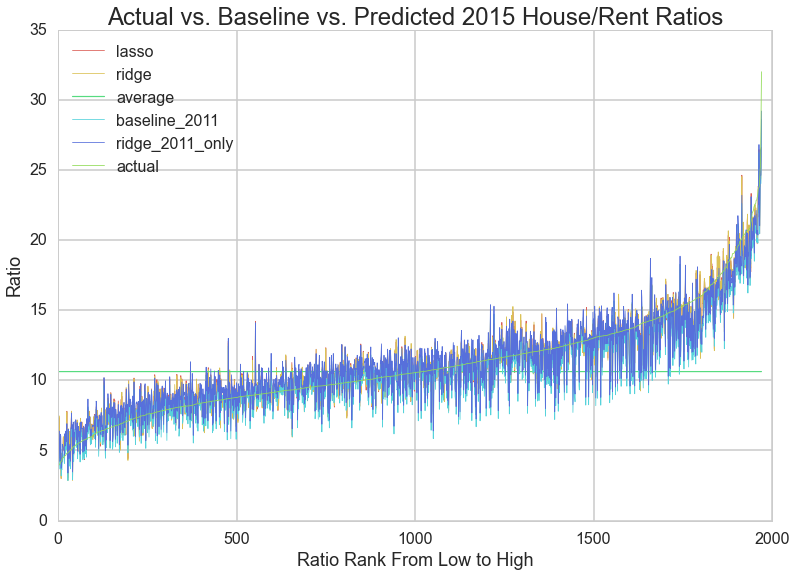

In [80]:
# get nice colors for plotting
sns_colors = sns.color_palette("hls", 8)

m=0
n=ratio_2015_preds_df.shape[0]
lw = 0.8

plt.plot(ratio_2015_preds_df.lasso[m:n], color=sns_colors[0], linewidth=lw, label='lasso')
plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], linewidth=lw, label='ridge')
plt.plot(ratio_2015_preds_df.baseline[m:n], color=sns_colors[3], linewidth=1.2, label='average')
plt.plot(ratio_2015_preds_df.baseline_2011[m:n], color=sns_colors[4], linewidth=lw, label='baseline_2011')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], linewidth=lw, label='ridge_2011_only')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=lw, label='actual')
plt.legend(loc='best')
plt.title('Actual vs. Baseline vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

We realized that we had too much data to visualize all the different predictions, baselines, and actual data points all together.  So we plotted just our best prediction (from the ridge regularized linear regression) against the baseline.  We also zoomed in on certain sections of the data.

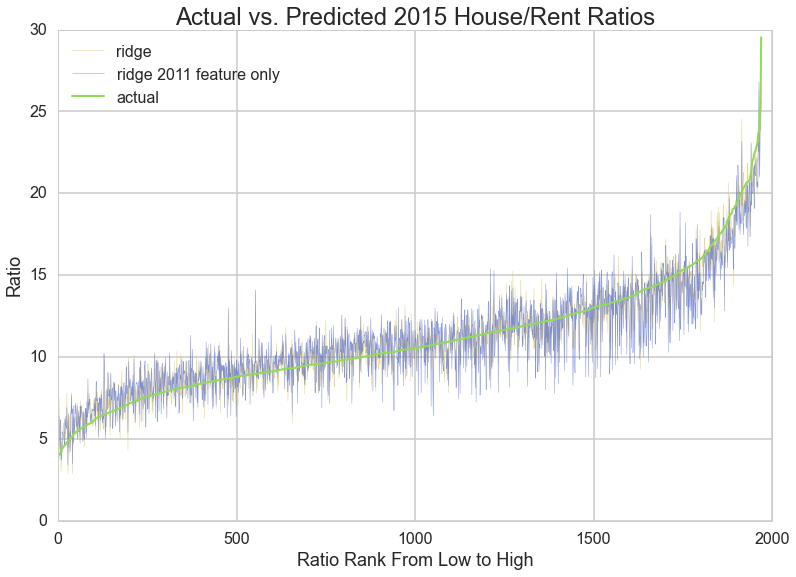

In [82]:
m=0
n=1970
lw = 1

plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], alpha=.7, linewidth=.5, label='ridge')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], alpha=.7, linewidth=.5, label='ridge 2011 feature only')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=2, label='actual')
plt.legend(loc='best')
plt.title('Actual vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

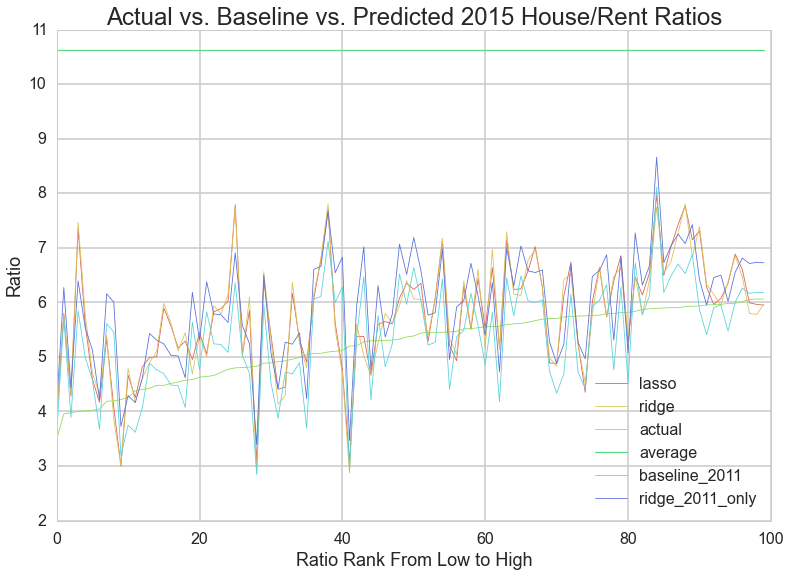

In [81]:
m=0
n=100
lw = 0.8

plt.plot(ratio_2015_preds_df.lasso[m:n], color=sns_colors[0], linewidth=lw, label='lasso')
plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], linewidth=lw, label='ridge')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=lw, label='actual')
plt.plot(ratio_2015_preds_df.baseline[m:n], color=sns_colors[3], linewidth=1.2, label='average')
plt.plot(ratio_2015_preds_df.baseline_2011[m:n], color=sns_colors[4], linewidth=lw, label='baseline_2011')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], linewidth=lw, label='ridge_2011_only')
plt.legend(loc='best')
plt.title('Actual vs. Baseline vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

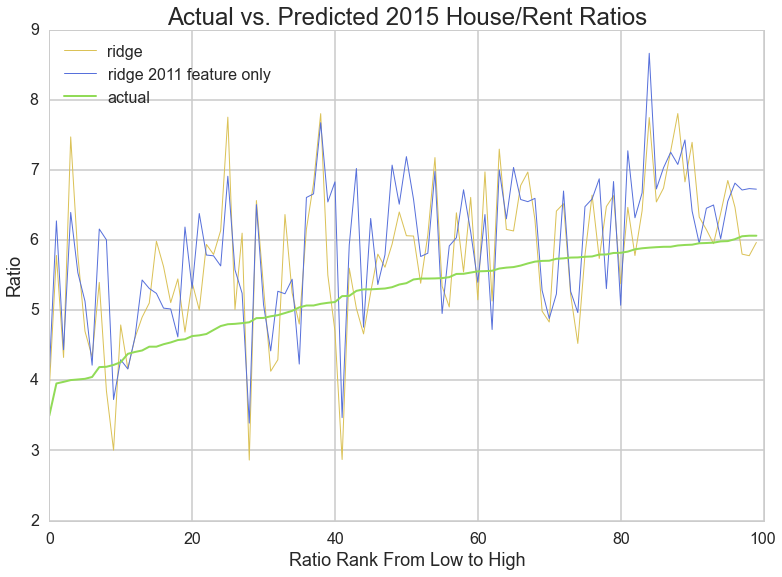

In [83]:
m=0
n=100
lw = 1

plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], linewidth=1, label='ridge')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], linewidth=1, label='ridge 2011 feature only')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=2, label='actual')
plt.legend(loc='best')
plt.title('Actual vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

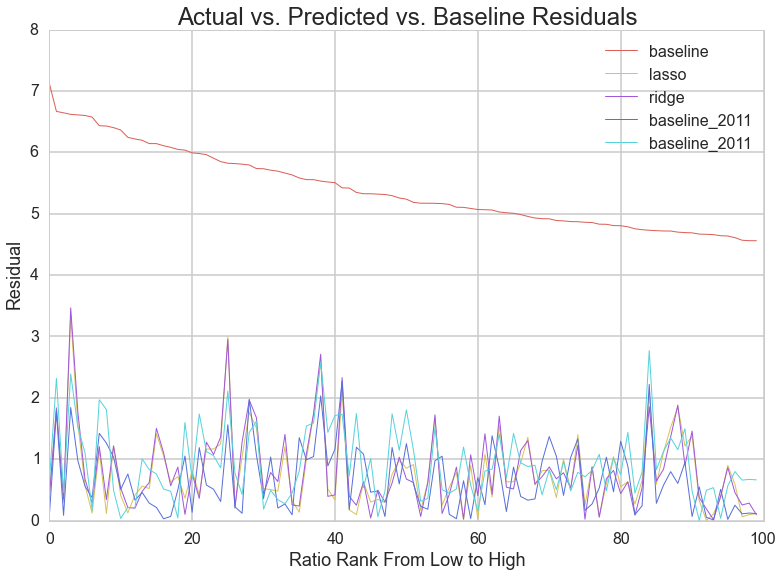

In [84]:
lw=1
# plt.plot(ratio_2015_preds_df.actual[m:n], color='b', linewidth=0.5, label='actual')
plt.plot(abs(ratio_2015_preds_df.baseline[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[0], linewidth=lw, label='baseline')
plt.plot(abs(ratio_2015_preds_df.lasso[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[1], linewidth=lw, label='lasso')
plt.plot(abs(ratio_2015_preds_df.ridge[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[6], linewidth=lw, label='ridge')
plt.plot(abs(ratio_2015_preds_df.baseline_2011[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[5], linewidth=lw, label='baseline_2011')
plt.plot(abs(ratio_2015_preds_df.ridge_2011_only[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[4], linewidth=lw, label='baseline_2011')


plt.legend(loc='best')
plt.title('Actual vs. Predicted vs. Baseline Residuals', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Residual', fontsize=18)
plt.show()

<a id="conclusion"></a>
# 5. Conclusion

What were our findings?
Evaluate each model and talk about next steps.